In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd #pandas to create small dataframes 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
import math
import os
import xgboost as xgb
from xgboost import XGBClassifier
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
import gc
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from numpy import nan
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [2]:
#reading
df_final_train = read_hdf('Data/fea_sample/storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf('Data/fea_sample/storage_sample_stage5.h5', 'test_df',mode='r')

In [3]:
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,jaccard_followers,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,11,15,6,8,0,0,0,...,1.983700e-06,-1.545089e-13,8.108439e-13,1.719704e-14,1.355369e-12,-4.675319e-13,1.128586e-06,-6.616715e-14,9.771079e-13,4.160012e-14
1,764724,584026,1,14,22,21,16,0,0,0,...,1.814309e-11,-8.291694e-12,2.563717e-13,1.281176e-14,1.721622e-12,-2.623926e-11,1.217700e-10,-8.572859e-12,6.524193e-12,7.967180e-15
2,708341,1771379,1,3,4,21,27,0,1,0,...,1.481440e-11,-1.121582e-12,8.231800e-13,1.698321e-13,9.421850e-12,-2.591678e-11,5.295544e-10,-1.736737e-11,3.577419e-10,5.031308e-12
3,1163731,575776,1,3,2,10,13,0,0,0,...,7.499367e-13,-1.813118e-15,2.588928e-14,6.755012e-17,4.660713e-13,-8.934707e-13,1.016153e-11,-9.086205e-14,6.296062e-12,3.111466e-15
4,80115,1473881,1,3,55,83,99,1,12,0,...,-4.362490e-15,-7.612177e-12,5.340783e-15,1.265847e-06,3.967624e-14,-2.265826e-14,6.615999e-13,1.035491e-11,1.342895e-13,1.048048e-04


In [4]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'num_followers_s',
       'num_followees_s', 'num_followers_d', 'num_followees_d',
       'inter_followers', 'inter_followees', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'adar_index', 'follows_back', 'same_comp', 'shortest_path', 'weight_in',
       'weight_out', 'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4',
       'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
       'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2',
       'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
       'svd_v_d_6'],
      dtype='object')

In [5]:
def preferential_attachment(df):
    '''Calculates product of followers/followees of source and dest node'''
    df['pref_attachment_followers'] = df['num_followers_s']*df['num_followers_d']
    df['pref_attachment_followees'] = df['num_followees_s']*df['num_followees_d']
    
    return df

In [6]:
df_final_train = preferential_attachment(df_final_train)
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,jaccard_followers,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attachment_followers,pref_attachment_followees
0,273084,1505602,1,11,15,6,8,0,0,0,...,8.108439e-13,1.719704e-14,1.355369e-12,-4.675319e-13,1.128586e-06,-6.616715e-14,9.771079e-13,4.160012e-14,66,120
1,764724,584026,1,14,22,21,16,0,0,0,...,2.563717e-13,1.281176e-14,1.721622e-12,-2.623926e-11,1.217700e-10,-8.572859e-12,6.524193e-12,7.967180e-15,294,352
2,708341,1771379,1,3,4,21,27,0,1,0,...,8.231800e-13,1.698321e-13,9.421850e-12,-2.591678e-11,5.295544e-10,-1.736737e-11,3.577419e-10,5.031308e-12,63,108
3,1163731,575776,1,3,2,10,13,0,0,0,...,2.588928e-14,6.755012e-17,4.660713e-13,-8.934707e-13,1.016153e-11,-9.086205e-14,6.296062e-12,3.111466e-15,30,26
4,80115,1473881,1,3,55,83,99,1,12,0,...,5.340783e-15,1.265847e-06,3.967624e-14,-2.265826e-14,6.615999e-13,1.035491e-11,1.342895e-13,1.048048e-04,249,5445


In [7]:
df_final_test = preferential_attachment(df_final_test)
df_final_test.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,jaccard_followers,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attachment_followers,pref_attachment_followees
0,848424,784690,1,6,6,14,9,1,0,0,...,4.341620e-13,5.535504e-14,9.994077e-10,-5.791914e-10,3.512351e-07,-2.486660e-09,2.771146e-09,1.727695e-12,84,54
1,1519975,1264299,1,8,9,5,7,3,1,0,...,8.795111e-13,4.216424e-15,1.407730e-12,-9.849278e-13,4.451865e-11,-7.676829e-13,2.163617e-11,4.783712e-14,40,63
2,1441135,977791,1,21,35,31,30,2,1,0,...,4.297122e-12,4.506379e-13,1.084646e-11,-6.904259e-10,2.599102e-05,-2.116916e-11,2.615364e-10,4.609087e-13,651,1050
3,706809,185810,1,0,1,1,0,0,0,0,...,0.000000e+00,0.000000e+00,4.974658e-13,-8.832726e-14,1.693701e-12,-3.361621e-11,2.436551e-11,3.285120e-14,0,0
4,120585,539098,1,73,28,122,0,54,0,0,...,7.083183e-14,2.106447e-06,1.208173e-12,-2.722431e-14,1.976888e-12,1.766524e-11,2.396370e-13,8.069914e-05,8906,0


In [8]:
# https://stackoverflow.com/questions/31789160/convert-select-columns-in-pandas-dataframe-to-numpy-array

def svd_dot_product(df):
    '''Calculates dot product of source and dest node features'''
    svd_list_followers =[]
    svd_list_followees = []
    source_columns_followers = ['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6'] 
    source_columns_followees = ['svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']
    dest_columns_followers = ['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']
    dest_columns_followees = ['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']
    s_array_followers = df[source_columns_followers].to_numpy()
    s_array_followees = df[source_columns_followees].to_numpy()
    d_array_followers = df[dest_columns_followers].to_numpy()
    d_array_followees = df[dest_columns_followees].to_numpy()
    for i in range(0,len(s_array_followers)):
        out = np.dot(s_array_followers[i],d_array_followers[i])
        out1 = np.dot(s_array_followees[i], d_array_followees[i])
        svd_list_followers.append(out)
        svd_list_followees.append(out1)
    return svd_list_followers, svd_list_followees

In [9]:
df_final_train['svd_dot_followers'], df_final_train['svd_dot_followees'] = svd_dot_product(df_final_train)
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,jaccard_followers,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attachment_followers,pref_attachment_followees,svd_dot_followers,svd_dot_followees
0,273084,1505602,1,11,15,6,8,0,0,0,...,1.355369e-12,-4.675319e-13,1.128586e-06,-6.616715e-14,9.771079e-13,4.160012e-14,66,120,1.114951e-11,2.238777e-12
1,764724,584026,1,14,22,21,16,0,0,0,...,1.721622e-12,-2.623926e-11,1.217700e-10,-8.572859e-12,6.524193e-12,7.967180e-15,294,352,2.756748e-21,2.849583e-21
2,708341,1771379,1,3,4,21,27,0,1,0,...,9.421850e-12,-2.591678e-11,5.295544e-10,-1.736737e-11,3.577419e-10,5.031308e-12,63,108,2.858553e-21,8.449751e-21
3,1163731,575776,1,3,2,10,13,0,0,0,...,4.660713e-13,-8.934707e-13,1.016153e-11,-9.086205e-14,6.296062e-12,3.111466e-15,30,26,9.566028e-24,7.850310e-24
4,80115,1473881,1,3,55,83,99,1,12,0,...,3.967624e-14,-2.265826e-14,6.615999e-13,1.035491e-11,1.342895e-13,1.048048e-04,249,5445,1.787370e-08,1.326668e-10


In [10]:
df_final_test['svd_dot_followers'], df_final_test['svd_dot_followees'] = svd_dot_product(df_final_test)
df_final_test.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,jaccard_followers,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attachment_followers,pref_attachment_followees,svd_dot_followers,svd_dot_followees
0,848424,784690,1,6,6,14,9,1,0,0,...,9.994077e-10,-5.791914e-10,3.512351e-07,-2.486660e-09,2.771146e-09,1.727695e-12,84,54,8.425175e-20,2.074802e-17
1,1519975,1264299,1,8,9,5,7,3,1,0,...,1.407730e-12,-9.849278e-13,4.451865e-11,-7.676829e-13,2.163617e-11,4.783712e-14,40,63,2.555420e-20,9.427446e-22
2,1441135,977791,1,21,35,31,30,2,1,0,...,1.084646e-11,-6.904259e-10,2.599102e-05,-2.116916e-11,2.615364e-10,4.609087e-13,651,1050,1.496802e-10,7.328804e-10
3,706809,185810,1,0,1,1,0,0,0,0,...,4.974658e-13,-8.832726e-14,1.693701e-12,-3.361621e-11,2.436551e-11,3.285120e-14,0,0,1.777563e-37,0.000000e+00
4,120585,539098,1,73,28,122,0,54,0,0,...,1.208173e-12,-2.722431e-14,1.976888e-12,1.766524e-11,2.396370e-13,8.069914e-05,8906,0,1.505807e-25,1.699884e-10


In [11]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [12]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9596918028108725 Test Score 0.9248156832921394
Estimators =  50 Train Score 0.9799322968398436 Test Score 0.9275127423172892
Estimators =  100 Train Score 0.9884962360491634 Test Score 0.9182211321241851
Estimators =  150 Train Score 0.994324585412977 Test Score 0.9011104310570953
Estimators =  200 Train Score 0.997427859496825 Test Score 0.8895416896742132


Text(0.5,1,'Estimators vs score at depth of 5')

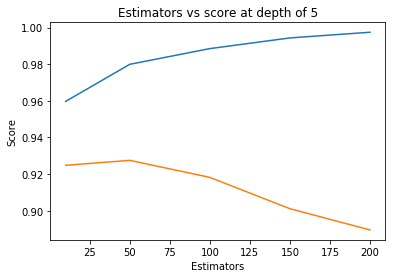

In [13]:
# https://stackoverflow.com/questions/66097701/how-can-i-fix-this-warning-in-xgboost
import warnings
warnings.filterwarnings("ignore")

estimators = [10,50,100,150,200]
train_scores = []
test_scores = []
for i in estimators:
    clf = XGBClassifier(n_estimators=i, eval_metric='logloss', max_depth=5)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'Test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9747533755295696 Test Score 0.9273436002300468
depth =  9 Train Score 0.9948567229977956 Test Score 0.9272095946147455
depth =  11 Train Score 0.9987440594009666 Test Score 0.9263665046473949
depth =  15 Train Score 1.0 Test Score 0.926257841505569
depth =  20 Train Score 1.0 Test Score 0.9280057901907358
depth =  35 Train Score 1.0 Test Score 0.9291459211030257
depth =  50 Train Score 1.0 Test Score 0.9291459211030257
depth =  70 Train Score 1.0 Test Score 0.9291459211030257
depth =  130 Train Score 1.0 Test Score 0.9291459211030257


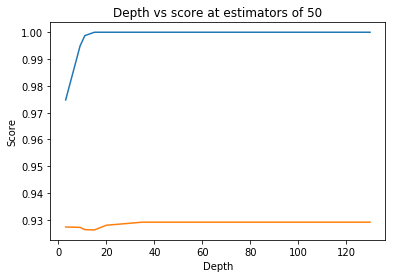

In [14]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = XGBClassifier(n_estimators= 50, eval_metric='logloss', max_depth=i)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'Test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at estimators of 50')
plt.show()

In [15]:
param_dist = {"n_estimators": sp_randint(5,50),
              "max_depth": sp_randint(20,70),
              'learning_rate': [1, 0.5, 0.1, 0.01, 0.05]}

clf =  XGBClassifier(eval_metric='logloss')

rf_random = RandomizedSearchCV(clf,param_distributions=param_dist,n_iter=5,cv=3,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.97344886 0.97480752 0.97508454 0.97043995 0.96766507]
mean train scores [0.99531534 0.99753313 0.9979206  0.9911792  0.98851339]


In [16]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=45, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=36, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [17]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=45, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=36, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9981823841897551
Test f1 score 0.9291234924409716


In [19]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


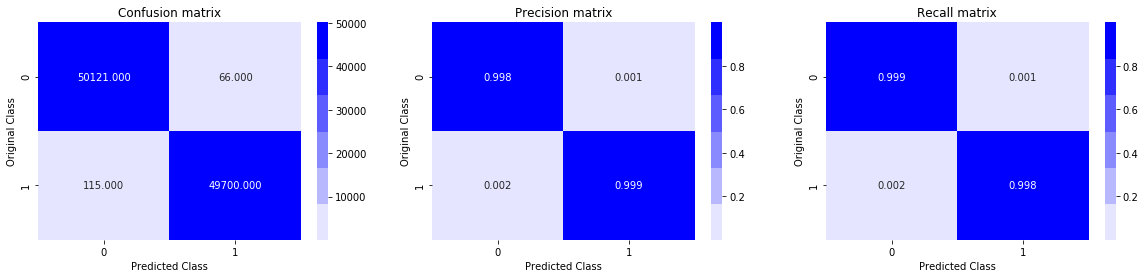

Test confusion_matrix


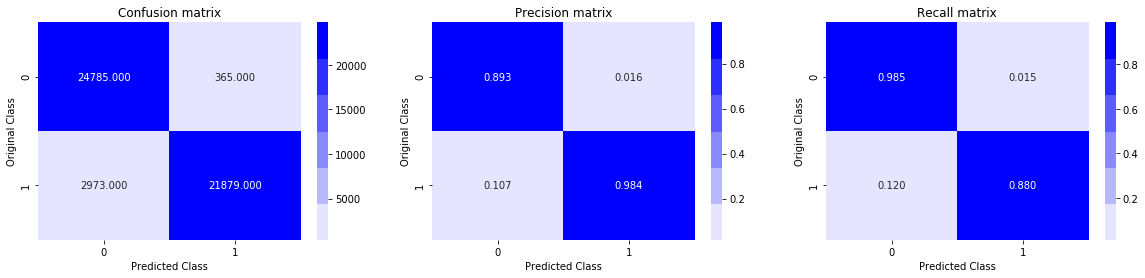

In [20]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

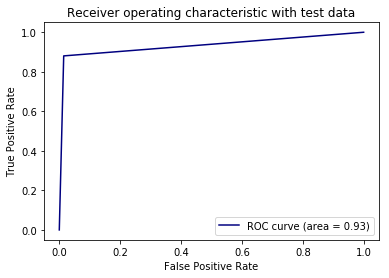

In [21]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

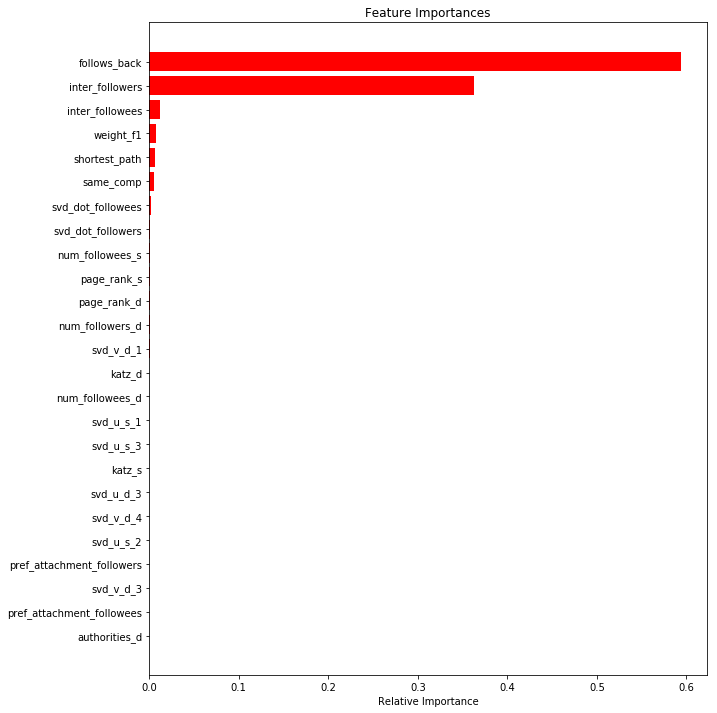

In [22]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [23]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Hyperparameter", "Train F1 Score", 'Test F1 Score']
x.add_rows(
    [
        ['RandomForestClassifier', 'n_estimators = 121, max_depth = 14', '0.9652533106548414', '0.9241678239279553'],
        ['XGBClassifier', 'n_estimators=36, max_depth = 45', '0.9981823841897551' , '0.9291234924409716'],
    ]
)
print(x)

+------------------------+------------------------------------+--------------------+--------------------+
|         Model          |           Hyperparameter           |   Train F1 Score   |   Test F1 Score    |
+------------------------+------------------------------------+--------------------+--------------------+
| RandomForestClassifier | n_estimators = 121, max_depth = 14 | 0.9652533106548414 | 0.9241678239279553 |
|     XGBClassifier      |  n_estimators=36, max_depth = 45   | 0.9981823841897551 | 0.9291234924409716 |
+------------------------+------------------------------------+--------------------+--------------------+


### Conclusion:

<pre>
<b>Q: Please elaborate on the step by step procedure you followed to solve this case study.</b>
<p><font color='red'>Steps to create 'storage_sample_stage5.h5' file:</font>
1. Re-execute the Fb_featurization iPyNB with some changes(addition of number of followers and followees) such that final table contains 55 columns.(These columns are obtained from the facebook friend recommentation case study. Apply all the concepts taught in the course case study videos(jaccard similarity, hits score, pagerank etc) to obtain these 55 features).
2. The train data rows are 100002 and test data rows are 50002.
3. Store this data in HDFS file because this data is large. So, it cannot be stored in csv all at a time. Also, this file stores data in hierarchial structure in order to quickly access any part of the file any time.</p>
<p><font color='red'>Steps to add new features as stated in the assignment:</font>
1. The new features(svd_dot_followers/followees, preferntial_attachment_followers/followees) were obtained as stated in the reference documents shared.
2. These new features were then added in the test and train pandas dataframe.
3. XgBoost Algorithms was used to calculate/check the error metric.</p>
<p><font color='red'>Observations:</font>
1. The business requirement of high precision and high recall(high F1 score) is satisfied upto certain extend after using XGBoost. This model is slighlty better than the Random Forest Classifier but not as good to be replaced in place of Random Forest Classifier.
2. After all the hyperparameter tuning, it was found that 'Train f1 score - 0.9981823841897551' and 'Test f1 score - 0.9291234924409716' which indicates that the model is slightly overfitting.
3. 'follows_back' continues to remain the most important feature as seen previously for Random Forest Classifier as well.
4. The newly added features hold some importance in the classification task of whether a link can be established from source node to destination node or not. 'svd_dot(followers/followees)' is the most important features out of the added new features.</p>
</pre>